In [10]:
import sys
from tqdm import tqdm
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# import umap 
import umap.umap_ as umap # should be installed by "pip install umap-learn" (maybe)

from torchvision.utils import make_grid
from sklearn.manifold import MDS
from torchvision import models, transforms
import torchvision
import json
import os
from copy import deepcopy
from easydict import EasyDict # pip install easydict

sys.path.append("/home/jinsu/workstation/project/trade_off")
from wb_data import WaterBirdsDataset, get_loader, get_transform_cub

In [11]:
# Utils
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def print_param_change(old_model, new_model):
    """
    old_model : torch.nn.module
    new_model : torch.nn.module
    """
    for (name, parameter), (name_, parameter_) in zip(old_model.named_parameters(), new_model.named_parameters()):
        param_shape = parameter.shape
        final_value = parameter[tuple([idx-1 for idx in param_shape])]
        final_value_ = parameter_[tuple([idx-1 for idx in param_shape])]
        
        print(f"{name}: {final_value} -> {final_value_}")
        
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        try:
            module_out = module_out.detach().cpu()
            self.outputs.append(module_out)  # .detach().cpu().numpy()
        except Exception as e:
            print(e)
            self.outputs.append(module_out)

    def clear(self):
        self.outputs = []


def ChangeDictKeyOrder(old_dict, new_key_order, round=None):
    
    if round is None: 
        new_dict =  {key: old_dict[key] for key in new_key_order}
    else:
        new_dict =  {key: np.round(old_dict[key], round) for key in new_key_order}
    return new_dict

def plot_umap(embeddings, meta_results,  label_type, legend_labels_dict, reduced_dim=2, num_data=None, method='umap',
              offset=0, figsize=(12, 9), save_id=None, save=True,
              ftype='.png', title_suffix=None, annotate_points=None, seed=42, display_image=True):
    """
    Visualize embeddings with U-MAP
    - embeddings : embeddings
    - meta_results : corresponding results > dict_keys(['labels', 'spurioiuss', 'groups', 'confidences', 'predictions'])
    """
    labels = np.array(meta_results[label_type+'s'])
    
    if num_data is None:
        embeddings = embeddings
    elif offset == 0:
        np.random.seed(seed)
        num_data = np.min((num_data, len(embeddings)))
        sample_ix = np.random.choice(np.arange(len(embeddings)),
                                     size=num_data, replace=False)

        embeddings = embeddings[sample_ix]
        
        labels = labels[sample_ix]
    else:
        embeddings = embeddings[offset:offset + num_data]
        labels = labels[offset:offset + num_data]
    
    if label_type == 'confidence':
        colors = np.array(labels)
    else:    
        colors = np.array(labels).astype(int)
        num_colors = len(np.unique(colors))
        if num_colors==2:
            colors_template = ['midnightblue', 'red']
        elif num_colors==4: # Group
            colors_template = ['midnightblue', 'darkorange', 'red', 'royalblue']
        colors = [colors_template[val] for val in np.array(labels)] 
    
    fig = plt.figure(figsize=figsize)

    # zero_embedding = np.zeros_like(embeddings[0].shape)
    
    if method == 'umap':
        standard_embedding = umap.UMAP(random_state=42, n_components=reduced_dim).fit_transform(embeddings)
    else:  # method == 'mds'
        standard_embedding = MDS(n_components=reduced_dim,
                                 random_state=42).fit_transform(embeddings)
    
    if reduced_dim==2:
        # Continuous
        if label_type == 'confidence':
            scatter = plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1],
                    c=colors, s=1.0, alpha=1,
                    cmap=plt.cm.get_cmap('coolwarm'))
        # Discrete
        else:
            plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=colors, s=1.0, alpha=1)

    else:
        assert reduced_dim==3
        
        ax = fig.add_subplot(111, projection='3d')
        
        # Continuous
        if label_type == 'confidence':
            scatter = ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1],  standard_embedding[:, 2],
                    c=colors, s=1.0, alpha=1,
                    cmap=plt.cm.get_cmap('coolwarm'))
        
        # Discrete
        else:
            ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1],  standard_embedding[:, 2],
                    c=colors, s=1.0, alpha=1)
            
    if label_type == 'confidence':
        cbar = plt.colorbar(scatter)
        cbar.set_label('Confidence')
    else:
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_template]
        legend_labels = [legend_labels_dict[label_type][label] for label in range(len(np.unique(labels)))]
        if reduced_dim==2:
            plt.legend(legend_elements, legend_labels)
        else:
            assert reduced_dim==3
            ax.legend(legend_elements, legend_labels)
    
    
            
    suffix = '' if title_suffix is None else f' {title_suffix}'
    plt.title(f'Color by [{label_type}] labels{suffix}')
    
    if save:
        fpath = f'{save_id}{ftype}'
        plt.savefig(fname=fpath, dpi=300, bbox_inches="tight")
        print(f'Saved {method} to {fpath}!')
        
    if display_image:
        plt.show()
    plt.close('all')
    del standard_embedding
    

def plot_umap_all(embeddings_train, embeddings_val, embeddings_test, meta_results_train, meta_results_val, meta_results_test,
                  label_type, legend_labels_dict, passed_dfs, reduced_dim=2,  method='umap', figsize=(24, 6), save_id=None, save=True,
              ftype='.png', title_suffix=None, annotate_points=None, seed=42, display_image=True, cls_ebd = None, group_mean_ebd = None):
    """
    Visualize embeddings with U-MAP
    - embeddings : embeddings
    - meta_results : corresponding results > dict_keys(['labels', 'spurioiuss', 'groups', 'confidences', 'predictions'])
    """

    labels_train = np.array(meta_results_train[label_type+'s'])
    labels_val = np.array(meta_results_val[label_type+'s'])
    labels_test = np.array(meta_results_test[label_type+'s'])
    
    n_train = len(labels_train)
    n_val = len(labels_val)
    n_test = len(labels_test)
    
    # print(n_train, n_val, n_test)
    total_labels = np.concatenate([labels_train, labels_val, labels_test], axis=0)
    total_embeddings = np.concatenate([embeddings_train, embeddings_val, embeddings_test], axis=0)
    # print("total_embedddings.shape : ", total_embeddings.shape)
    # print(total_labels.shape)
    # print(total_embeddings.shape)


    if (cls_ebd is not None) or (group_mean_ebd is not None):
        print("Add zero embedding to umap-pool")
        zero_ebd = np.zeros((1, total_embeddings[0].shape[0]))
        total_embeddings = np.concatenate([total_embeddings, zero_ebd], axis=0)
        # print("total_embedddings.shape : ", total_embeddings.shape)

    if cls_ebd is not None: # (2, 2048) add to embedding pool
        print("Add class embedding to umap-pool")
        total_embeddings = np.concatenate([total_embeddings, cls_ebd], axis=0)
        # print("total_embedddings.shape : ", total_embeddings.shape)
        # Label : 0, 1
    
    if  group_mean_ebd is not None:
        # 각각 (4, 2024), (4, 2024), (4, 2024)
        # label : 0, 1 ,2, 3
        print("Add group (mean) embedding to umap-pool")
        (add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test,
                              add_group_labels_train, add_group_labels_val, add_group_labels_test) = group_mean_ebd 
        
        add_group_mean_ebds = np.concatenate([add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test], axis=0)
        total_embeddings = np.concatenate([total_embeddings, add_group_mean_ebds])
        
        # print("total_embedddings.shape : ", total_embeddings.shape)
    
    if method == 'umap':
        standard_embedding = umap.UMAP(random_state=42, n_components=reduced_dim).fit_transform(total_embeddings)
    else:  # method == 'mds'
        standard_embedding = MDS(n_components=reduced_dim,
                                 random_state=42).fit_transform(total_embeddings)
    
    standard_embedding_train = standard_embedding[: n_train]
    standard_embedding_val = standard_embedding[n_train: n_train + n_val]
    standard_embedding_test = standard_embedding[n_train+n_val : n_train+n_val+n_test]
    

    offset_for_add = n_train+n_val+n_test
    if (cls_ebd is not None) or (group_mean_ebd is not None):
        standard_zero_ebd = standard_embedding[offset_for_add]
        offset_for_add = offset_for_add + 1 
        # print("standard zero ebd' shape:", standard_zero_ebd.shape)
        
    if cls_ebd is not None:
        standard_cls_ebd = standard_embedding[offset_for_add: offset_for_add + 2]
        # print("standard clas ebd' shape:", standard_cls_ebd.shape)
        offset_for_add = offset_for_add + 2
    if group_mean_ebd is not None:
        standard_group_mean_ebd_train = standard_embedding[offset_for_add: offset_for_add + 5] # Mean + Group 4
        standard_group_mean_ebd_val = standard_embedding[offset_for_add + 5: offset_for_add + 10]
        standard_group_mean_ebd_test = standard_embedding[offset_for_add + 10: offset_for_add + 15]
        # print("standard group ebd' shape:", standard_group_mean_ebd_test.shape)
                    
    fig = plt.figure(figsize=figsize)
    
    
    # Zero -> Cls 1 
    # Zero -> Cls 2
    
    # standard_zero_ebd : all the ploting
    # standard_cls_ebd : all the ploting 
    
    if reduced_dim == 2:
        fig, axs =plt.subplots(2,3, figsize=figsize,  gridspec_kw={'height_ratios': [2.5, 1]})
    
    else:
        assert reduced_dim ==3
        fig, axs =plt.subplots(2,3, figsize=figsize, subplot_kw={"projection": "3d"},  gridspec_kw={'height_ratios': [2.5, 1]})
        # fig, axs =plt.subplots(2,3, figsize=figsize,   gridspec_kw={'height_ratios': [3, 1]})
    
    for idx, (each_standard_embedding, labels, each_standard_group_mean_ebd, each_df, sub_title) in enumerate(zip([standard_embedding_train, standard_embedding_val, standard_embedding_test],
                                                                           [labels_train, labels_val, labels_test],
                                                                           [standard_group_mean_ebd_train, standard_group_mean_ebd_val, standard_group_mean_ebd_test],
                                                                           passed_dfs,
                                                                           ["Train set", "Val set", "Test set"])):
        
    
        # Group : train/val/test
        if label_type == 'confidence':
            colors = np.array(labels)
        else:    
            colors = np.array(labels).astype(int)
            num_colors = len(np.unique(colors))
            if num_colors==2:
                colors_template = ['midnightblue', 'red']
            elif num_colors==4: # Group
                colors_template = ['midnightblue', 'darkorange', 'red', 'royalblue']
            colors = [colors_template[val] for val in np.array(labels)] 
           
        
        
        if reduced_dim==2:
            # ax = fig.add_subplot(2, 3, idx+1)
            # Continuous
            if label_type == 'confidence':
                scatter = axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1],
                        c=colors, s=1.0, alpha=1,
                        cmap=plt.cm.get_cmap('coolwarm'))
            # Discrete
            else:
                axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1], c=colors, s=1.0, alpha=1)

            if cls_ebd is not None:
                for idx_, ebd in enumerate(standard_cls_ebd):
                    axs[0][idx].annotate(f"Class {idx_}", xytext=ebd, xy=standard_zero_ebd, arrowprops=dict(arrowstyle="<-"))
            if group_mean_ebd is not None:
                for idx_, ebd in enumerate(each_standard_group_mean_ebd):
                    if idx_ ==0:
                        continue # Pass the average vector.
                    
                    axs[0][idx].annotate(f"Group {idx_}", xytext=ebd, xy=standard_zero_ebd, arrowprops=dict(arrowstyle="<-"))
            
            # ax = fig.add_subplot(2, 3, idx+4)
            axs[1][idx].axis('tight')
            axs[1][idx].axis('off')
            table = axs[1][idx].table(cellText=each_df.values, colLabels=each_df.columns, rowLabels=each_df.index, loc='center')
            # ax.set_box_aspect(1)
        else:
            assert reduced_dim==3
            
            
            # axs[0][idx] = fig.add_subplot(2, 3, idx+1, projection='3d')
            
            # Continuous
            if label_type == 'confidence':
                scatter = axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1],  each_standard_embedding[:, 2],
                        c=colors, s=1.0, alpha=1,
                        cmap=plt.cm.get_cmap('coolwarm'))
            
            # Discrete
            else:
                axs[0][idx].scatter(each_standard_embedding[:, 0], each_standard_embedding[:, 1],  each_standard_embedding[:, 2],
                        c=colors, s=1.0, alpha=1)
            
            
            if cls_ebd is not None:
                for idx_, ebd in enumerate(standard_cls_ebd):
                    axs[0][idx].text(ebd[0],ebd[1],ebd[2], f"Label {idx_}", size=8)
                    axs[0][idx].arrow3D(standard_zero_ebd[0],standard_zero_ebd[1],standard_zero_ebd[2], ebd[0]-standard_zero_ebd[0],ebd[1]-standard_zero_ebd[1],ebd[2]-standard_zero_ebd[2], mutation_scale=20, arrowstyle="-|>", fc='red')
            if group_mean_ebd is not None:
                for idx_, ebd in enumerate(each_standard_group_mean_ebd):
                    if idx_ ==0:
                        continue # Pass the average vector.
                    
                    # axs[0][idx].annotate(f"Group {idx}", xytext=ebd, xy=standard_zero_ebd, arrowprops=dict(arrowstyle="<-"))
                    axs[0][idx].text(ebd[0],ebd[1],ebd[2], f"Group {idx_}", size=8)
                    # print(standard_zero_ebd[0],standard_zero_ebd[1],standard_zero_ebd[2], ebd[0],ebd[1],ebd[2])                    
                    axs[0][idx].arrow3D(standard_zero_ebd[0],standard_zero_ebd[1],standard_zero_ebd[2], ebd[0]-standard_zero_ebd[0],ebd[1]-standard_zero_ebd[1],ebd[2]-standard_zero_ebd[2], mutation_scale=20, arrowstyle="-|>", linestyle='dashed')
            
            
            axs[1][idx].axis('tight')
            axs[1][idx].axis('off')
            # ax = fig.add_subplot(2, 3, idx+4)
            table = axs[1][idx].table(cellText=each_df.values, colLabels=each_df.columns, rowLabels=each_df.index, loc='center')
            axs[1][idx].set_box_aspect([1, 1, 1])
            
        table.scale(1, 2)  # Adjust the scale factors to control the size of the table
        
            
        if label_type == 'confidence':
            cbar = plt.colorbar(scatter)
            cbar.set_label('Confidence')
        else:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_template]
            legend_labels = [legend_labels_dict[label_type][label] for label in range(len(np.unique(labels)))]
            axs[0][idx].legend(legend_elements, legend_labels)
            
            
        axs[0][idx].set_title(sub_title)
                
    suffix = '' if title_suffix is None else f' {title_suffix}'
    plt.suptitle(f'Color by [{label_type}] labels{suffix}', size=20)
    # plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        
    if save:
        fpath = f'{save_id}{ftype}'
        plt.savefig(fname=fpath, dpi=300, bbox_inches="tight")
        print(f'Saved {method} to {fpath}!')
        
    if display_image:
        plt.show()
    plt.close('all')
    del standard_embedding
    
    
from scipy.spatial.distance import cdist
def compute_mean_vector(array, axis=0):
    mean_vector = np.mean(array, axis=axis)
    return mean_vector

def compute_vector_norm(vector):
    norm = np.linalg.norm(vector)
    return norm

def compute_averaged_pairwise_distance(array):
    num_samples = array.shape[0]
    pairwise_distances = cdist(array, array)
    average_distance = np.sum(pairwise_distances) / (num_samples * (num_samples - 1))
    return average_distance

# Measures : norm, mean_vector, compactness
def GetGroupWiseStatEbd(embeddings, group_labels):
    # in Each group
    statistics = {
        'mean_vector' : {},
        'mean_vector_norm' : {},
        'pairwise_distance' : {},
    }
    
    # Full datasets
    mean_vector = compute_mean_vector(embeddings, axis=0)
    vector_norm = compute_vector_norm(mean_vector)
    pairwise_distance = compute_averaged_pairwise_distance(embeddings)
    
    statistics['mean_vector']['full'] = mean_vector
    statistics['mean_vector_norm']['full'] = vector_norm
    statistics['pairwise_distance']['full'] = pairwise_distance

    for group in np.unique(group_labels): # 0, 1, 2, 3
        group_indices = np.where(group_labels == group)[0]
        group_embeddings = embeddings[group_indices]
        
        mean_vector = compute_mean_vector(group_embeddings, axis=0)
        vector_norm = compute_vector_norm(mean_vector)
        pairwise_distance = compute_averaged_pairwise_distance(group_embeddings)
        
        statistics['mean_vector'][group] = mean_vector
        statistics['mean_vector_norm'][group] = vector_norm
        statistics['pairwise_distance'][group] = pairwise_distance
    
    return statistics

def GetGroupWiseStatConf(confidences, group_labels):
    
    # in Each group
    statistics = {}
    # Full datasets

    mean_conf = np.mean(confidences)
    statistics['full'] = mean_conf

    for group in np.unique(group_labels): # 0, 1, 2, 3
        group_indices = np.where(group_labels == group)[0]
        group_confidences = confidences[group_indices]

        mean_conf = np.mean(group_confidences)
        statistics[group] = mean_conf
    
    return statistics


        



In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

from matplotlib.text import Annotation

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)
        
def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

import numpy as np
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [ ]:
import clip

In [13]:
class VisHandler():
    """
    - 1) 웬만하면 Embedding 파일만 받아서.
      - 1.1) Adapter 학습 하고 난 다음의 pth도 저장해놨으니, 불러와서 임베딩 똑같이 뽑을 수 있음.
      - 1.2) Linear probing / Adapter 등 학습 시 results/...에 결과 저장됨. 
    """
    def __init__(self, image_embedding_dir="data/embeddings_unnormalized/waterbirds/RN50/clip.json",
                 text_class_embedding_dir = "data/embeddings_unnormalized/waterbirds/clip_class.json",
                 args,
                 arch='RN50'):
        """
        Initialized by arguments for "single run"
        """
        self.image_embedding_dir = image_embedding_dir
        self.text_class_embedding_dir = text_class_embedding_dir
        self.args = args
        self.arch = arch
        self.device = (torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'))
    
        # self.train_results = EasyDict(read_pickle_file(os.path.join(self.run_path, 'full_dict.pickle')))
        self.final_results = {} # Best Train / Val / Text
        
        if self.args.dataset == "waterbirds" :
            
            self.legend_labels_dict = {"target": {0: "Landbird (Major class)", 1: "Waterbird (Minor class)"}, "spurious": {0: "Land-background", 1:"Water-background"}, 
                            "group": {0: "Landbird on Land (Major group in Major class)", 1: "Landbird on Water (Minor group in Major class)",
                                        2: "Waterbird on Land (Minor group in Minor class)", 3: "Waterbird on Water (Major group in Minor class)"},
                            "prediction": {0: "Pred. to Landbird (Major class)",
                                            1: "Pred. to Waterbird (Minor class)"}}

        
        self.model = None
        self.cls_weight = None # Text
        self.cls_norm = None # Text
        self.cls_bias = None # Text
        self.group_wise_stat_ebd = {}
        self.group_wise_stat_conf = {}

    def SaveDataTransforms(self):
        # Not augment (same to train/val/test)
        self.transform = get_transform_cub(target_resolution=self.target_resolution, train=False, augment_data=False)
    
    def SaveWaterbirdsDatasets(self):
        self.train_set = WaterBirdsDataset(basedir=self.args.train_dir, split="train", transform=self.transform)
        self.val_set = WaterBirdsDataset(basedir=self.args.val_fgbg_dir, split="val", transform=self.transform)
        self.test_set = WaterBirdsDataset(basedir=self.args.test_fgbg_root_dir, split="test", transform=self.transform)
        self.val_fg_set = WaterBirdsDataset(basedir=self.args.val_fg_dir, split="val", transform=self.transform)
        self.test_fg_set = WaterBirdsDataset(basedir=self.args.test_fg_root_dir, split="test", transform=self.transform)
    
    def SaveWaterbirdsLoaders(self):
        loader_kwargs = {'batch_size': 512, 'num_workers': 4, 'pin_memory': True}
        self.train_loader = get_loader(self.train_set, train=False, reweight_groups=None, reweight_classes=None, reweight_places=None, **loader_kwargs)
        self.val_loader = get_loader(self.val_set, train=False, reweight_groups=None, reweight_classes=None, reweight_places=None, **loader_kwargs)
        self.test_loader = get_loader(self.test_set, train=False, reweight_groups=None, reweight_classes=None, reweight_places=None, **loader_kwargs)
        self.val_fg_loader = get_loader(self.val_fg_set, train=False, reweight_groups=None, reweight_classes=None, reweight_places=None, **loader_kwargs)
        self.test_fg_loader = get_loader(self.test_fg_set, train=False, reweight_groups=None, reweight_classes=None, reweight_places=None, **loader_kwargs)
        
    # def LoadModel(self, pt_name): # NOTE Adapter 학습 이후에 results/.. 에 저장된 pth 파일 불러와서 받을 수 있게끔.
    #     if "RN" in self.arch:
    #         if "RN50" == self.arch:
    #             model, preprocess = clip.load(self.args.backbone, device='cuda', jit=False)
                
    #             self.feat_dim = model.fc.in_features  # (2048)
    #             model.fc = torch.nn.Linear(self.feat_dim, self.n_classes)
                
    #     # origin_model = deepcopy(model)
    #     model.load_state_dict(torch.load(os.path.join(self.run_path, pt_name)))         
    #     # print_param_change(origin_model, model)
                                 
    #     model.to(self.device)
    #     model.eval()
    #     self.model = deepcopy(model)
    #     del model
    
    def SaveClsStat(self):
        # self.cls_weight = ""self.model.fc.weight.clone().detach().cpu().numpy()""
        self.cls_weight = # NOTE "Text_embedding.json 받아서 저장"
        
        self.cls_norm = np.linalg.norm(self.cls_weight, axis=1) # l2 norm
        
    
    def SaveFinalResults(self, results.json):
        performances = []
        metric = None
        for k, v in self.train_results.items():
            if ("val_fgbg_50" in k) and (not "n_val_fgbg_50" in k):
                ep = k.split("ep")[0].split('(')[-1]
                if (metric == None):
                    metric = list(v.keys())
                performances.append([ep] + list(v.values()))

        performances = np.array(performances)

        df = pd.DataFrame(performances, columns = ['Epoch'] + metric)
        df.set_index('Epoch', inplace=True)

        new_columns_order = ['weighted_mean_acc','worst_acc', 'acc_0_0', 'acc_0_1', 'acc_1_0', 'acc_1_1', 'mean_acc', ]
        df = df.reindex(columns = new_columns_order)
        df = df.astype('float64')
        if 'worst' in val_on:
            best_epoch = df['worst_acc'].argmax()
        elif 'avg' in val_on:
            best_epoch = df['weighted_mean_acc'].argmax()

        self.final_results = {}
        
        self.final_results["best_epoch"] = best_epoch
        self.final_results["best_train_accs"] = ChangeDictKeyOrder(self.train_results[f"train({best_epoch}ep)"], ['mean_acc']+new_columns_order[1:-1], round = 4)
        self.final_results["best_val_accs"] = ChangeDictKeyOrder(self.train_results[f"test({best_epoch}ep)(val_fgbg_50)"], new_columns_order, round = 4)
        self.final_results["best_test_accs"] =ChangeDictKeyOrder(self.train_results[f"test({best_epoch}ep)(test_fgbg_50)"], new_columns_order, round = 4)
        self.final_results["best_val_fg_accs"] = ChangeDictKeyOrder(self.train_results[f"test({best_epoch}ep)(val_fg_50)"], new_columns_order, round = 4)
        self.final_results["best_test_fg_accs"] = ChangeDictKeyOrder(self.train_results[f"test({best_epoch}ep)(test_fg_50)"], new_columns_order, round = 4)
    
    def GetEmbeddings(self, dataloader):
        # # NOTE Adapter 학습 이후 모델 받아서 추출하는 라인 추가해야함.
        
        total_embeddings = []

        total_labels = []
        total_spuriouss = []
        total_groups = []
        # total_confidences = []
        total_predictions = [] # Zero-shot

        print('> Saving activations')

        with torch.no_grad():
            for i, data in enumerate(tqdm(dataloader, desc='Running inference')):
                embeddings, labels_dict = data
                labels = labels_dict["class"]
                groups = labels_dict["group"]
                places = labels_dict["spurious"]
                predicted = labels_dict["ebd_y_pred"]

                total_labels.extend(labels.numpy())
                total_groups.extend(groups.numpy())
                total_spuriouss.extend(places.numpy())
                total_predictions.extend(predicted.numpy())
                total_embeddings.extend(embeddings.numpy())
                
                del inputs; del labels; del groups; del places; del confidence; del logits; del predicted

        total_embeddings = np.concatenate(total_embeddings) # (# of full data, feat_dim)


        total_meta_results = {"targets" : total_labels, "spuriouss": total_spuriouss, "groups" : total_groups, 
                             "predictions": total_predictions}
        
        return total_embeddings, total_meta_results
        
    def VisRep(self, model, dataloader, vis_on, label_types=['group', 'target', 'spurious', 'prediction'], num_data=None, reduced_dim=2,
                          figsize=(8, 6), save=True, ftype='.png', title_suffix=None, save_id_suffix=None,
                          annotate_points=None, plot_mds=False, seed=42):
        """_summary_

        Args:
            model (_type_): nn.Module
            dataloader (_type_): Dataset for visualization 
            vis_on (_type_): choice <- ["train", "val", "test", "val_fg", "test_fg"] (correspond to dataloader)
            label_types (_type_): ['confidence', 'target', 'spurious', 'group', 'prediction']
            num_data (_type_, optional): for Random sampling(No..) Defaults to None=Full..
            reduced_dim (int, optional): _description_. Defaults to 2.
        """
        
        total_embeddings, total_meta_results = self.GetEmbeddings(model, dataloader)
        
        title_suffix= f'([{self.learning_way}] Rep. on [{vis_on}])'
        save_id_suffix = f'{self.learning_way}_{self.arch}-{self.train_on}-tr{self.confounding_degree}-final'     

        print(f'total_embeddings.shape: {total_embeddings.shape}')
        n_mult = 1
        pbar = tqdm(total=n_mult * len(label_types))
        for label_type in label_types:
            # For now just save both classifier ReLU activation layers (for MLP, BaseCNN)
            if save_id_suffix is not None:
                save_id = f'{reduced_dim}d_{label_type[0]}{label_type[-1]}_{vis_on}_{save_id_suffix}'
            else:
                save_id = f'{reduced_dim}d_{label_type[0]}{label_type[-1]}_{vis_on}'
                
            plot_umap(total_embeddings, total_meta_results, label_type, self.legend_labels_dict, reduced_dim, num_data, method='umap',
                        offset=0, figsize=figsize, save_id=save_id, save=save,
                        ftype=ftype, title_suffix=title_suffix, annotate_points=annotate_points,
                        seed=seed, display_image = True)
            # Add MDS
            if plot_mds:
                plot_umap(total_embeddings, total_meta_results, label_type, self.legend_labels_dict,  reduced_dim, num_data, method='mds',
                            offset=0, figsize=figsize, save_id=save_id, save=save,
                            ftype=ftype, title_suffix=title_suffix, annotate_points=annotate_points,
                            seed=seed, display_image = True)
            pbar.update(1)
    
    def VisRepAll(self, model, train_loader, val_loader, test_loader, label_types=['group', 'target', 'spurious', 'prediction'], num_data=None, reduced_dim=2,
                          figsize=(24, 6), save=True, ftype='.png', title_suffix=None, save_id_suffix=None,
                          annotate_points=None, plot_mds=False, seed=42, cls_ebd=None, group_mean_ebd=None):
        """
        - Projection all train/val/test sets to same sub-space. (thus same umap-structure)
        """
        
        # self.embeddings_df = pd.read_json(self.embedding_dir) # key : image_filename
        indices_to_convert = ['y', 'place', 'group', 'y_pred', 'split'] # str -> int
        self.embeddings_df.loc[indices_to_convert] = self.embeddings_df.loc[indices_to_convert].astype('int64')
        
        total_embeddings_train, total_meta_results_train = self.GetEmbeddings(train_loader)
        total_embeddings_val, total_meta_results_val = self.GetEmbeddings(val_loader)
        total_embeddings_test, total_meta_results_test = self.GetEmbeddings(test_loader)
        
        # print("====================================Final accuracy===========================================")
        # print("Train set group accuracy: ", self.final_results["best_train_accs"])
        # print("Val set group accuracy: ", self.final_results["best_val_accs"])
        # print("Test set group accuracy: ", self.final_results["best_test_accs"])
        
        # print("====================================Classifier Statistic ====================================")
        # # print("Classifier weight vector", self.cls_weight)
        # print("Classifier Norm", self.cls_norm)
        # print("============================================================================================")
        
        
        # Save Group-wise Statistics -> [(norm of mean_vector, mean-vector) / compactness] for [train/val/test]
        
        self.group_wise_stat_ebd['train'] = GetGroupWiseStatEbd(total_embeddings_train, np.array(total_meta_results_train["groups"]))
        self.group_wise_stat_ebd['val'] = GetGroupWiseStatEbd(total_embeddings_val, np.array(total_meta_results_val["groups"]))
        self.group_wise_stat_ebd['test'] = GetGroupWiseStatEbd(total_embeddings_test, np.array(total_meta_results_test["groups"]))
        
        # self.group_wise_stat_conf['train'] = GetGroupWiseStatConf(np.array(total_meta_results_train["confidences"]), np.array(total_meta_results_train["groups"]))
        # self.group_wise_stat_conf['val'] = GetGroupWiseStatConf(np.array(total_meta_results_val["confidences"]), np.array(total_meta_results_val["groups"]))
        # self.group_wise_stat_conf['test'] = GetGroupWiseStatConf(np.array(total_meta_results_test["confidences"]), np.array(total_meta_results_test["groups"]))
        
        # print("====================================Group-wise Statistics====================================")
        # for split in ["train", "val", "test"]:
        #     print(f"=========== {split} set ===========")
        #     # print(self.group_wise_stat_ebd[split]["mean_vector"])
        #     print("Norm of mean_vector", self.group_wise_stat_ebd[split]["mean_vector_norm"])
        #     print("Averaged Pair-wise l2-distance (kind of Divergence)", self.group_wise_stat_ebd[split]["pairwise_distance"])
        # print("============================================================================================")
        
            
        group_wise_indexes = ["Acc.", "Div.", "Centr. Norm."]
        columns = ["Avg.","Worst", "group0", "group1", "group2", "group3"]
        
        dfs =[]
        for split in ["train", "val", "test"]:
            # print(len(list(self.final_results[f"best_{split}_accs"].values())))
            # print(list(self.final_results[f"best_{split}_accs"].values()))
            # print(len([list(self.group_wise_stat[split]["pairwise_distance"].values())[0]] + [0] + list(self.group_wise_stat[split]["pairwise_distance"].values())[1:]))
            # print([list(self.group_wise_stat[split]["pairwise_distance"].values())[0]] + [0] + list(self.group_wise_stat[split]["pairwise_distance"].values())[1:])
            # print(len([list(self.group_wise_stat[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat[split]["mean_vector_norm"].values())[1:]))
            # print([list(self.group_wise_stat[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat[split]["mean_vector_norm"].values())[1:])
            
            if split=="train":
                values = [list(self.final_results[f"best_{split}_accs"].values()), 
                        [list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[1:],
                        [list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[1:], 
                        [list(self.group_wise_stat_conf[split].values())[0]] + [0] + list(self.group_wise_stat_conf[split].values())[1:]]
                # print(values)
                df = pd.DataFrame(values, index=group_wise_indexes, columns = columns)
                df = df.round(3)
                dfs.append(df)
            else:
                values = [list(self.final_results[f"best_{split}_accs"].values())[:-1], 
                        [list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["pairwise_distance"].values())[1:],
                        [list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[0]] + [0] + list(self.group_wise_stat_ebd[split]["mean_vector_norm"].values())[1:], 
                        [list(self.group_wise_stat_conf[split].values())[0]] + [0] + list(self.group_wise_stat_conf[split].values())[1:]]
                # print(values)
                df = pd.DataFrame(values, index=group_wise_indexes, columns = columns)
                df = df.round(3)s
                dfs.append(df)
                
            # print(dfs[-1])
        
        if cls_ebd is not None:
            cls_ebd = self.cls_weight # label : (2, 2024)
    
        if group_mean_ebd is not None:  # group label : (4, 2024) X 3
            add_group_labels_train = [group for group in self.group_wise_stat_ebd['train']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_train = [ebd for ebd in self.group_wise_stat_ebd['train']["mean_vector"].values()]
            add_group_labels_val = [group for group in self.group_wise_stat_ebd['val']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_val = [ebd for ebd in self.group_wise_stat_ebd['val']["mean_vector"].values()]
            add_group_labels_test = [group for group in self.group_wise_stat_ebd['test']["mean_vector"].keys()] # Waterbird
            add_group_mean_ebds_test = [ebd for ebd in self.group_wise_stat_ebd['test']["mean_vector"].values()]

            group_mean_ebd = (add_group_mean_ebds_train, add_group_mean_ebds_val, add_group_mean_ebds_test,
                              add_group_labels_train, add_group_labels_val, add_group_labels_test)
            
        title_suffix= f'([{self.learning_way}] Rep. on [tr+val+test])'
        save_id_suffix = f'{self.learning_way}_{self.arch}-{self.train_on}-tr{self.confounding_degree}-final-allset'     

        
        n_mult = 1
        pbar = tqdm(total=n_mult * len(label_types))
        for label_type in label_types:
            # For now just save both classifier ReLU activation layers (for MLP, BaseCNN)
            if save_id_suffix is not None:
                save_id = f'{reduced_dim}d_{label_type[0]}{label_type[-1]}_all_{save_id_suffix}'
            else:
                save_id = f'{reduced_dim}d_{label_type[0]}{label_type[-1]}_all'
            
            
            # print("save_id", save_id)
            
            plot_umap_all(total_embeddings_train, total_embeddings_val, total_embeddings_test, total_meta_results_train, total_meta_results_val, total_meta_results_test,
                  label_type, self.legend_labels_dict, dfs, reduced_dim, method='umap', figsize=figsize, save_id=save_id, save=save, ftype=ftype, title_suffix=title_suffix,
              annotate_points=annotate_points, seed=seed, display_image=True, cls_ebd = cls_ebd, group_mean_ebd = group_mean_ebd)
            
            if plot_mds:
                plot_umap_all(total_embeddings_train, total_embeddings_val, total_embeddings_test, total_meta_results_train, total_meta_results_val, total_meta_results_test,
                  label_type, self.legend_labels_dict, dfs, reduced_dim, method='mds', figsize=figsize, save_id=save_id, save=save, ftype=ftype, title_suffix=title_suffix,
              annotate_points=annotate_points, seed=seed, display_image=True, cls_ebd = cls_ebd, group_mean_ebd = group_mean_ebd)
            
            pbar.update(1)

In [ ]:
# Config
data_dir =  "data"
dataset= "waterbirds"
embeddings_dir = "embeddings_unnormalized" 
backbone "resnet50"
# val까지 fg-only로 하기엔 너무 투머치디테일. (단, 학습이라면..?)

# Set Visualization Handler
vis_handler = VisHandler(arch=arch)

# Load specific models (default : val_on_worst) 

vis_handler.LoadModel(pt_names[val_on]) # vis_handler.model 
vis_handler.SaveClsStat() # cls_weight, norm, bias
vis_handler.SaveFinalResults(val_on=val_on, pt_name = pt_names[val_on])

/home/jinsu/anaconda3/envs/dl_mmd/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jinsu/anaconda3/envs/dl_mmd/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## plot [train/val/test] reduced representation in same umap-subspace

> Saving activations


Running inference:  10%|█         | 1/10 [00:16<02:28, 16.54s/it]


> Saving activations


Running inference:  33%|███▎      | 1/3 [00:10<00:21, 10.57s/it]


> Saving activations


Running inference:   8%|▊         | 1/12 [00:13<02:27, 13.40s/it]


====================================Final accuracy===========================================
Train set group accuracy:  {'mean_acc': 0.9998, 'worst_acc': 0.9818, 'acc_0_0': 1.0, 'acc_0_1': 1.0, 'acc_1_0': 0.9818, 'acc_1_1': 1.0}
Val set group accuracy:  {'weighted_mean_acc': 0.9774, 'worst_acc': 0.7737, 'acc_0_0': 0.9913, 'acc_0_1': 0.8095, 'acc_1_0': 0.7737, 'acc_1_1': 0.971, 'mean_acc': 0.8941}
Test set group accuracy:  {'weighted_mean_acc': 0.9792, 'worst_acc': 0.8022, 'acc_0_0': 0.9925, 'acc_0_1': 0.8129, 'acc_1_0': 0.8022, 'acc_1_1': 0.9735, 'mean_acc': 0.8994}
====================================Classifier Statistic ====================================
Classifier Norm [0.9153644 0.9162815]
Classifier Bias [-0.00589746  0.0135225 ]


  0%|          | 0/5 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Add zero embedding to umap-pool
Add class embedding to umap-pool
Add group (mean) embedding to umap-pool
Saved umap to 2d_gp_all_ERM_resnet50-fgbg-tr95-final-allset.png!


<Figure size 2400x1000 with 0 Axes>

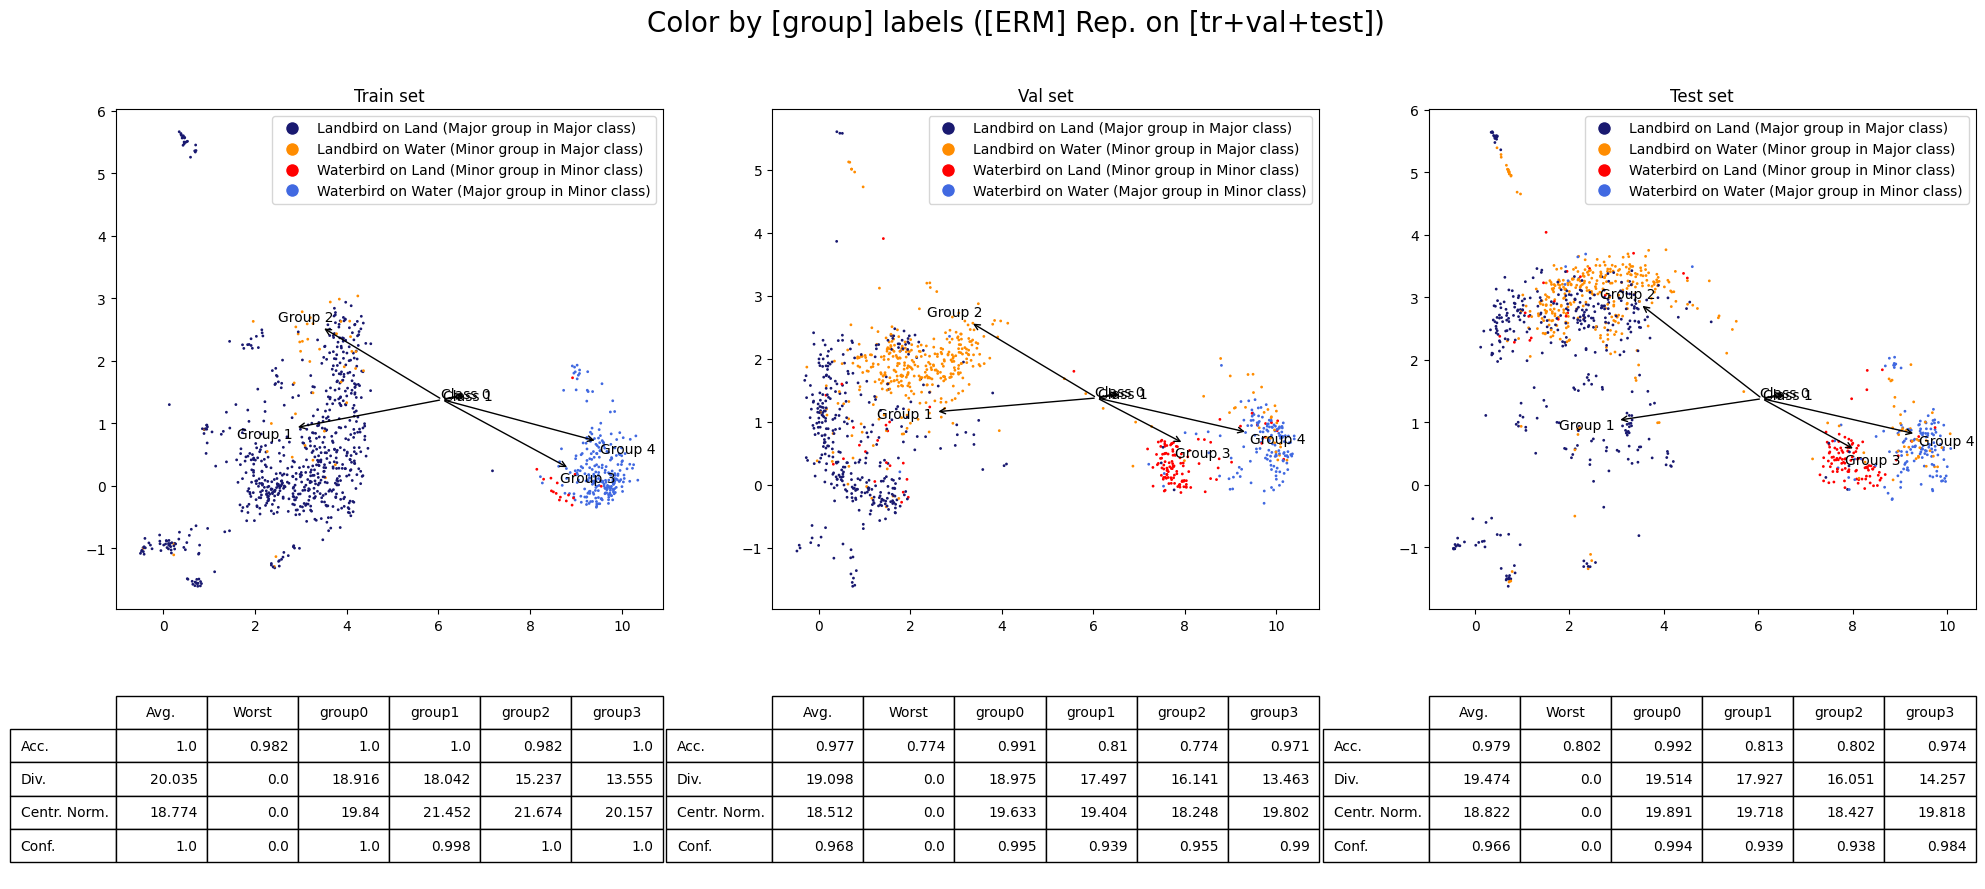

 20%|██        | 1/5 [00:17<01:08, 17.20s/it]

Add zero embedding to umap-pool
Add class embedding to umap-pool
Add group (mean) embedding to umap-pool
Saved umap to 2d_tt_all_ERM_resnet50-fgbg-tr95-final-allset.png!


<Figure size 2400x1000 with 0 Axes>

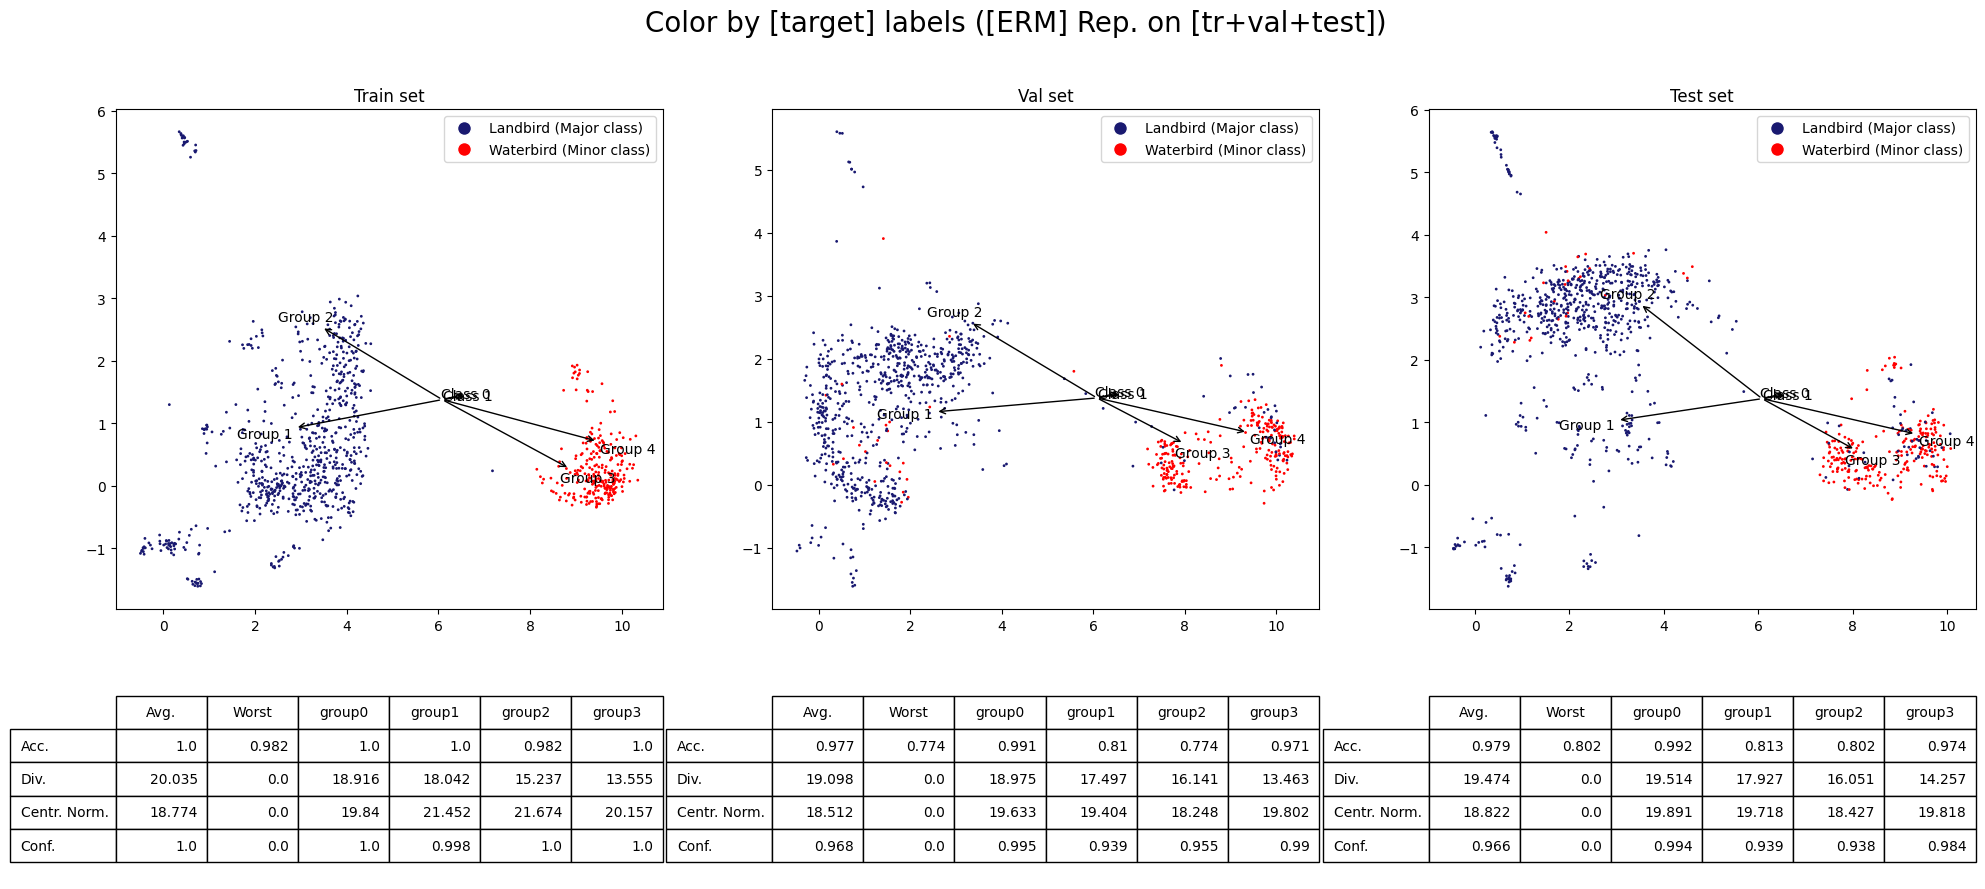

 40%|████      | 2/5 [00:29<00:43, 14.58s/it]

Add zero embedding to umap-pool
Add class embedding to umap-pool
Add group (mean) embedding to umap-pool
Saved umap to 2d_ss_all_ERM_resnet50-fgbg-tr95-final-allset.png!


<Figure size 2400x1000 with 0 Axes>

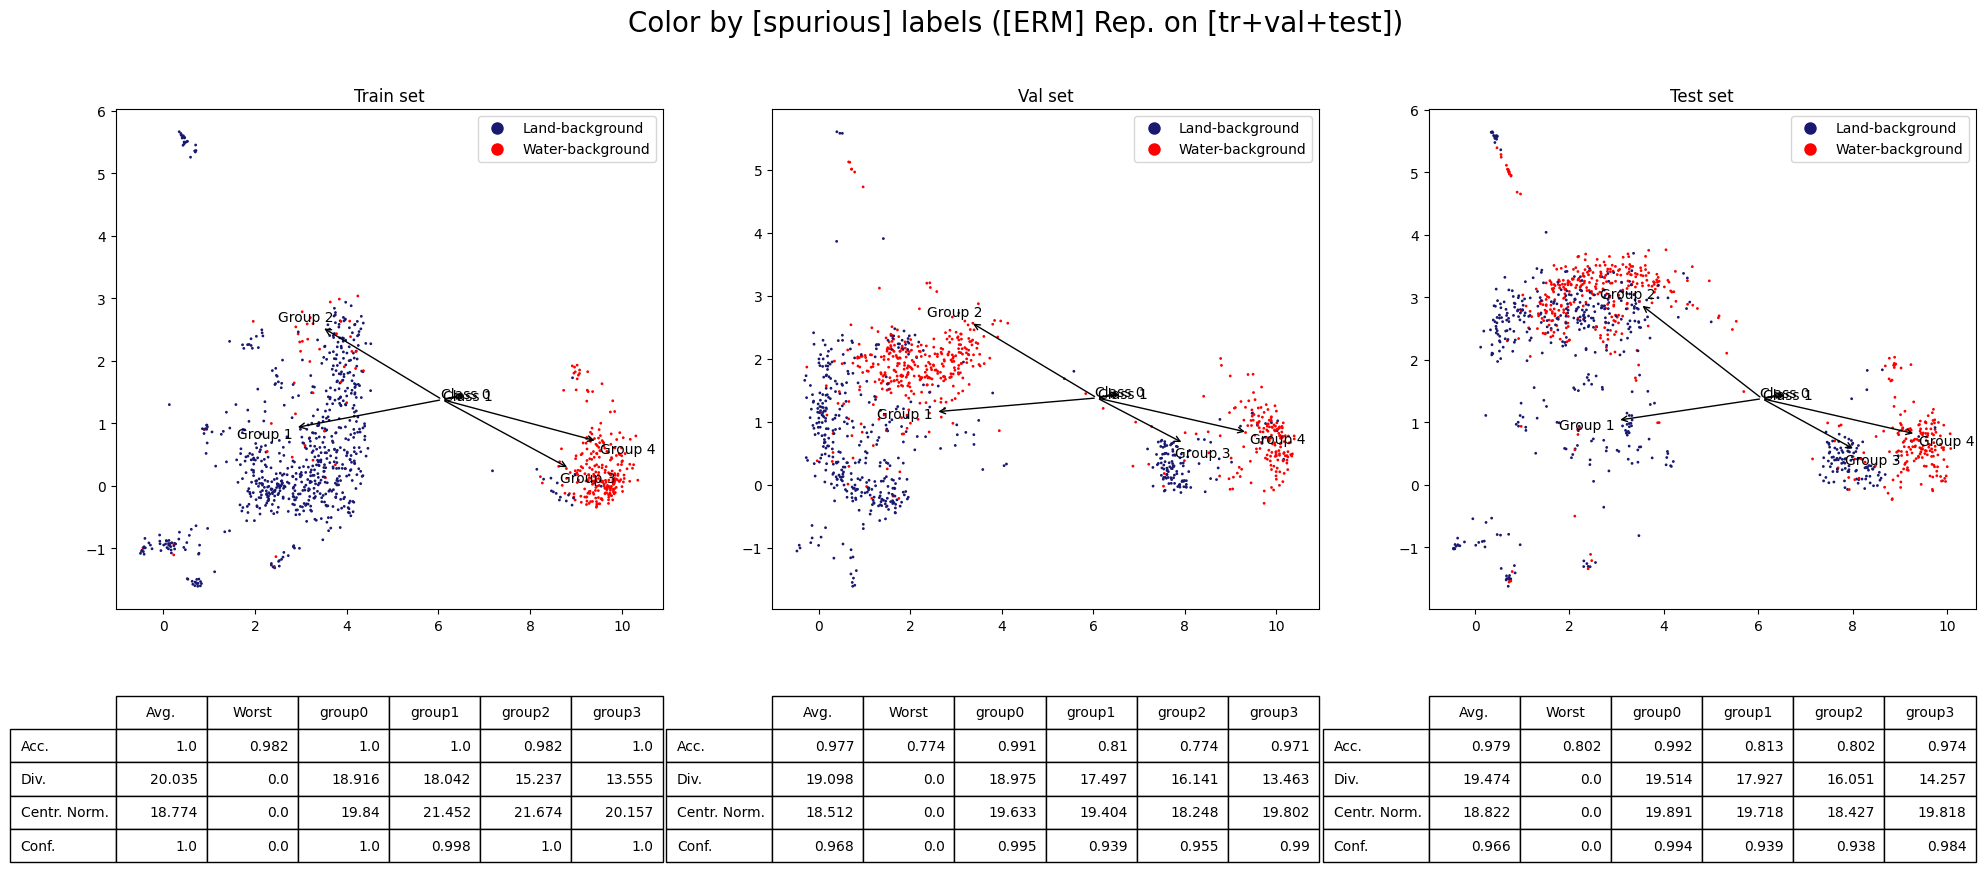

 60%|██████    | 3/5 [00:43<00:27, 13.89s/it]

Add zero embedding to umap-pool
Add class embedding to umap-pool
Add group (mean) embedding to umap-pool
Saved umap to 2d_pn_all_ERM_resnet50-fgbg-tr95-final-allset.png!


<Figure size 2400x1000 with 0 Axes>

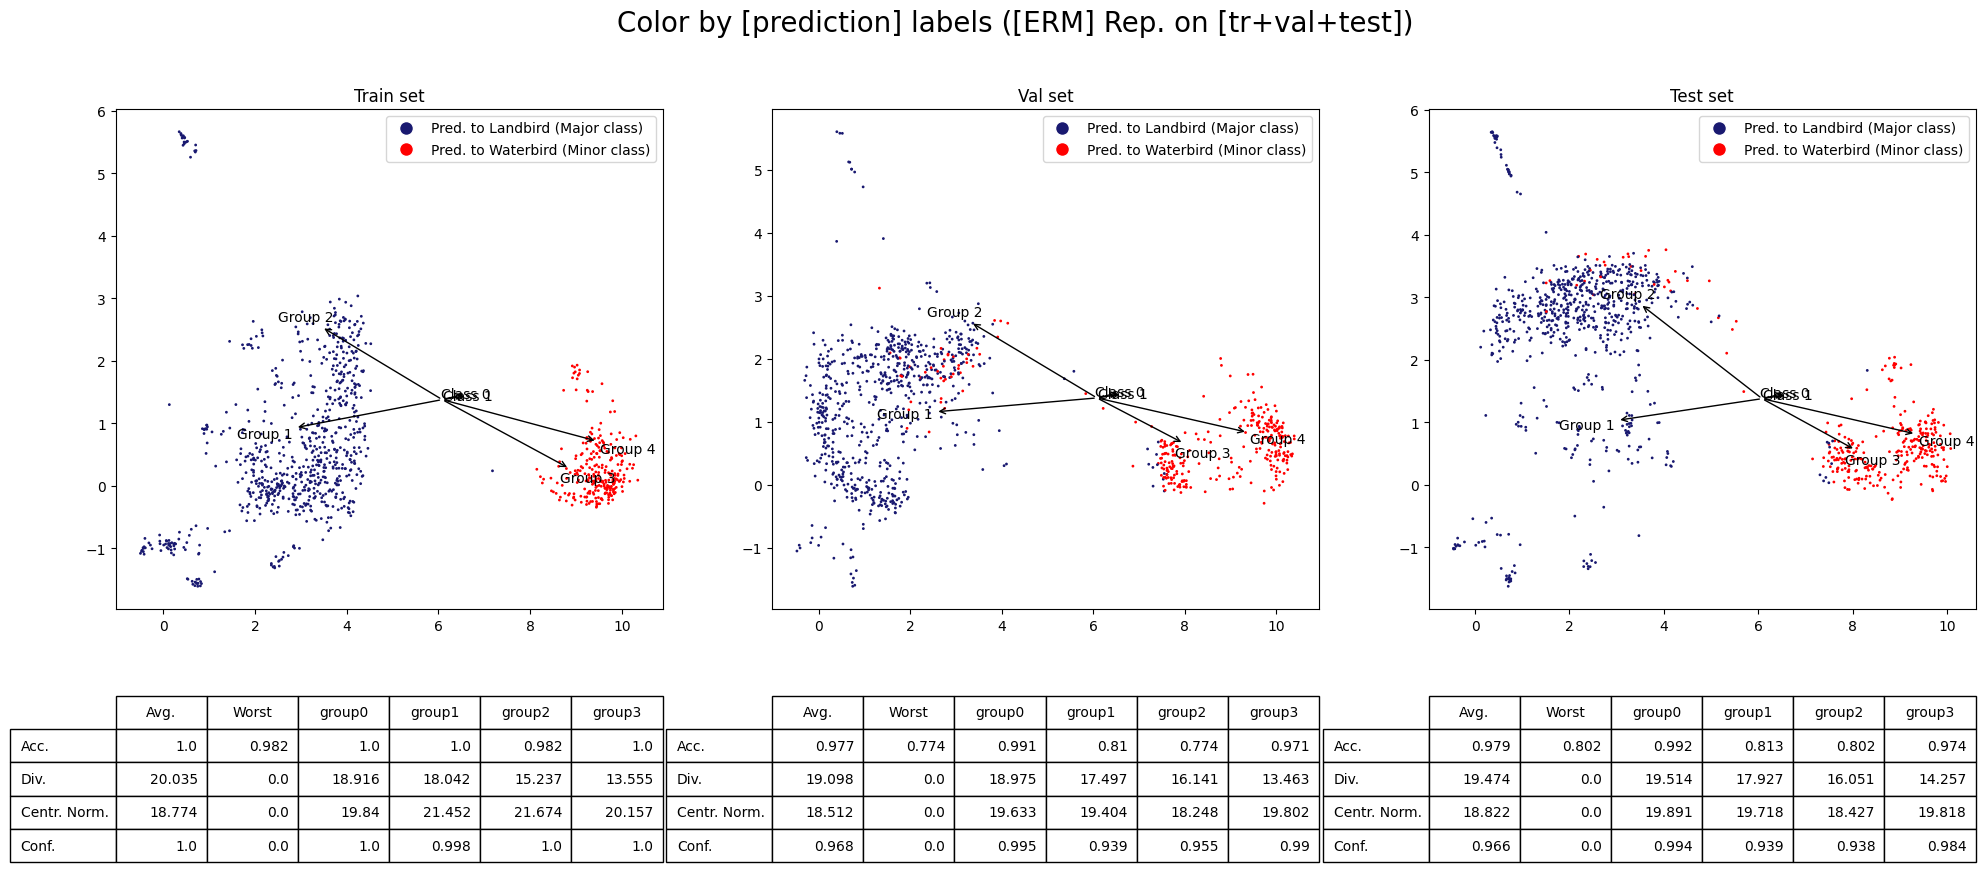

 80%|████████  | 4/5 [00:56<00:13, 13.64s/it]

Add zero embedding to umap-pool
Add class embedding to umap-pool
Add group (mean) embedding to umap-pool


/tmp/ipykernel_3452176/1405120380.py:268: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('coolwarm'))


Saved umap to 2d_ce_all_ERM_resnet50-fgbg-tr95-final-allset.png!


<Figure size 2400x1000 with 0 Axes>

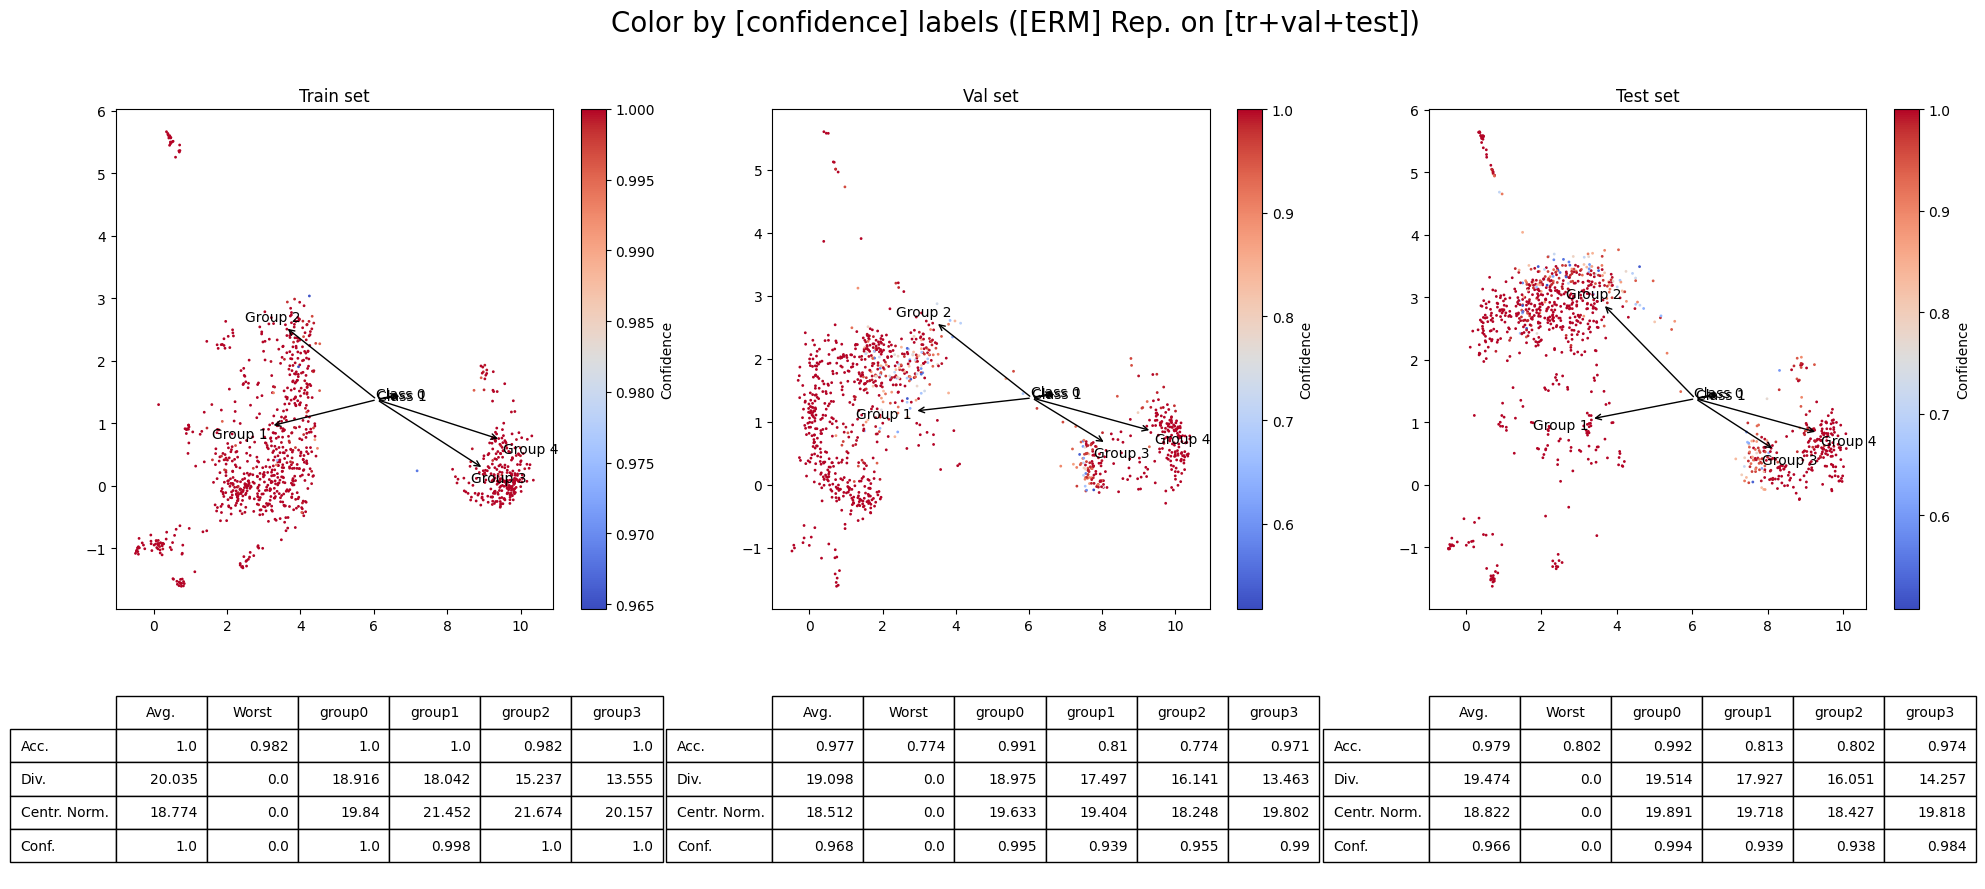

100%|██████████| 5/5 [01:09<00:00, 13.87s/it]


In [15]:
vis_handler.VisRepAll(vis_handler.model, vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader, reduced_dim=2, cls_ebd = True, group_mean_ebd = True, figsize=(24, 10))
# vis_handler.VisRepAll(vis_handler.model, vis_handler.train_loader, vis_handler.val_loader, vis_handler.test_loader, reduced_dim=3, cls_ebd = True, group_mean_ebd = True, figsize=(24, 10))